In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
target = "CPG"
SPY_daily = yf.download(target)
full_df = SPY_daily
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-10-20,0.00,9.08,9.08,9.08,6.285250,2000
2003-10-21,9.08,9.08,9.08,9.08,6.285250,0
2003-10-22,0.00,9.23,9.21,9.22,6.382163,1400
2003-10-23,0.00,9.19,9.16,9.18,6.354472,16900
2003-10-24,0.00,9.22,9.20,9.22,6.382163,8800
...,...,...,...,...,...,...
2024-02-15,6.34,6.73,6.33,6.70,6.700000,7048300
2024-02-16,6.71,6.84,6.67,6.80,6.800000,6824700
2024-02-20,6.81,6.89,6.78,6.84,6.840000,7050000


In [5]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

In [ ]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

In [8]:
nine_period_high = full_df['High'].rolling(window= 9).max()
nine_period_low = full_df['Low'].rolling(window= 9).min()
tenkan_sen = (nine_period_high + nine_period_low) /2
full_df['tenkan_sen_perc'] = tenkan_sen.pct_change(1)
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = full_df['High'].rolling(window=26).max()
period26_low = full_df['Low'].rolling(window=26).min()
kijun_sen = (period26_high + period26_low) / 2
full_df['kijun_sen_perc'] = kijun_sen.pct_change(1)
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
full_df['senkou_span_a_perc'] = senkou_span_a.pct_change(1)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = full_df['High'].rolling(window=52).max()
period52_low = full_df['Low'].rolling(window=52).min()
senkou_span_b = ((period52_high + period52_low) / 2).shift(26)
full_df['senkou_span_b_perc'] = senkou_span_b.pct_change(1)

var_list = [tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b]
names_list = ["tenkan_sen", "kijun_sen", "senkou_span_a", "senkou_span_b"]
for var, name in zip(var_list,names_list):
    colname = name+"_higher_close"
    full_df[colname] = [1 if a > b else 0 for a, b in zip(var, list(full_df["Close"]))]
    
full_df["tenkan_sen_higher_kijun_sen"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, kijun_sen)]
full_df["tenkan_sen_kijun_sen_DIFF"] = tenkan_sen - kijun_sen

full_df["senkou_span_a_higher_senkou_span_b"] = [1 if a > b else 0 for a, b in zip(senkou_span_a, senkou_span_b)]
full_df["senkou_span_a_senkou_span_b_DIFF"] = senkou_span_a - senkou_span_b

full_df["tenkan_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]
full_df["kijun_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(kijun_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]

full_df["tenkan_sen_cloudDIFF"] = tenkan_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]
full_df["kijun_sen_cloudDIFF"] = kijun_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]

full_df["positive_crossover"] = [1 if x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]
full_df["crossover"] = [1 if (x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0) or (x <= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]

crossover_above = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 > val2:
        crossover_above.append(1)
    else:
        crossover_above.append(0)

full_df["crossover_above"] = crossover_above

crossover_below = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [min(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 < val2:
        crossover_below.append(1)
    else:
        crossover_below.append(0)

full_df["crossover_below"] = crossover_below

full_df["positive_crossover_cloud"] = [1 if x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]
full_df["crossover_cloud"] = [1 if (x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0) or (x <= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]

all_ichimoku = ["tenkan_sen_perc", "kijun_sen_perc", "senkou_span_a_perc", "senkou_span_b_perc", 'tenkan_sen_higher_close','kijun_sen_higher_close','senkou_span_a_higher_close','senkou_span_b_higher_close','tenkan_sen_higher_kijun_sen','tenkan_sen_kijun_sen_DIFF','senkou_span_a_higher_senkou_span_b','senkou_span_a_senkou_span_b_DIFF','tenkan_sen_higher_cloud','kijun_sen_higher_cloud','tenkan_sen_cloudDIFF','kijun_sen_cloudDIFF','positive_crossover','crossover','crossover_above','crossover_below','positive_crossover_cloud','crossover_cloud']
#for col in all_ichimoku:
   # full_df=create_lagged_columns(full_df, 20, col)

full_df

,Open,High,Low,Close,Adj Close,Volume,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
2003-10-20,0.00,9.08,9.08,9.08,6.285250,2000,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
2003-10-21,9.08,9.08,9.08,9.08,6.285250,0,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
2003-10-22,0.00,9.23,9.21,9.22,6.382163,1400,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
2003-10-23,0.00,9.19,9.16,9.18,6.354472,16900,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
2003-10-24,0.00,9.22,9.20,9.22,6.382163,8800,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-15,6.34,6.73,6.33,6.70,6.700000,7048300,0.016733,0.000000,-0.003275,0.0,...,0,0,-1.050,-1.000,0,0,0,0,0,0
2024-02-16,6.71,6.84,6.67,6.80,6.800000,6824700,0.018025,0.000778,-0.006937,0.0,...,0,0,-0.935,-0.995,1,1,0,1,0,0
2024-02-20,6.81,6.89,6.78,6.84,6.840000,7050000,0.007698,0.003885,0.000000,0.0,...,0,0,-0.885,-0.970,0,0,0,0,0,0


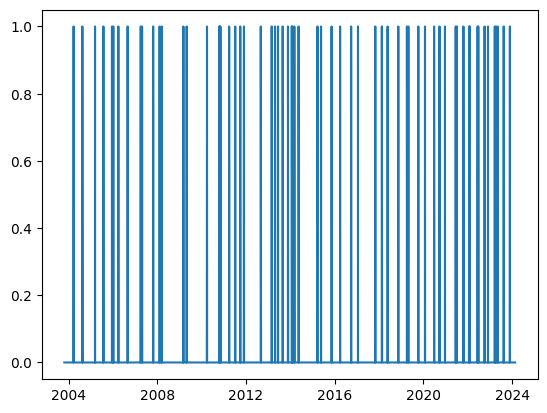

In [18]:
plt.plot(full_df.index, full_df['positive_crossover_cloud'])

In [19]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [ ]:
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close'], axis=1, inplace=True)